<a href="https://colab.research.google.com/github/mxhit-j/RajaramanLabSpikeSorting/blob/main/Rajaraman_Lab_DSSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## $\texttt{Do not load any of the cells: the files used are local and they won't run at your end}$.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 24.abf to 24.abf
Saving 23.abf to 23.abf
Saving 16.abf to 16.abf


In [ ]:
#@title Pre-reqs
!pip install neo
!pip install nixio
!pip install spikeinterface
!pip install ml_ms4alg
!pip install herdingspikes


the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release


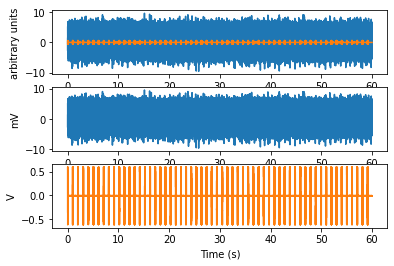

(600000, 2) (600000, 1) 0.0 ['mV' 'V']


In [ ]:

import neo
import nixio
import matplotlib.pyplot as plt
import quantities as pq
import numpy as np
import scipy


filename = '24.abf'
reader = neo.io.AxonIO(filename = filename)

#a few lines of test code
a_sigs = reader.get_analogsignal_chunk(block_index=0, seg_index=0, channel_indexes=[0,1])
a_sigs_float64 = reader.rescale_signal_raw_to_float(a_sigs, dtype= 'float64')
sampling_rate = reader.get_signal_sampling_rate()
start_t = reader.get_signal_t_start(block_index=0, seg_index=0, channel_indexes=[0,1])
units = reader.header['signal_channels']['units']

#notimplemented err for wavforms and spike times
#which makes sense cause this object isn't in either type
seg = reader.read_block().segments[0]
fig = plt.figure()
ax1 = fig.add_subplot(311)

ax1.set_ylabel('arbitrary units')
mint = 0 * pq.s
maxt = np.inf * pq.s
    
for i, asig in enumerate(seg.analogsignals):
    times = asig.times.rescale('s').magnitude
    asig = asig.magnitude
    ax1.plot(times, asig)

ax2 = fig.add_subplot(312, sharex = ax1)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel(units[0])
asig_ch0 = seg.analogsignals[0]
times = asig_ch0.times.rescale('s').magnitude
sig = asig_ch0.magnitude
ax2.plot(times, sig)

ax3 = fig.add_subplot(313, sharex = ax1)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel(units[1])
asig_ch1 = seg.analogsignals[1]
times = asig_ch1.times.rescale('s').magnitude
sig = asig_ch1.magnitude
ax3.plot(times, sig ,c = 'C1')


plt.show()


print(a_sigs.shape, sig.shape, start_t, units)



the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release


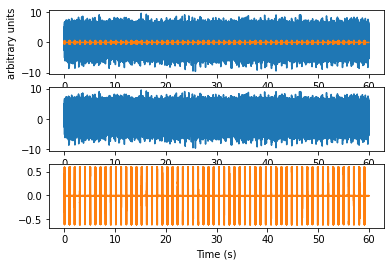

(600000, 2) (600000, 1) 0.0 ['' ''] 10000.0


In [ ]:
f_out = '24.raw'
w = neo.io.RawBinarySignalIO(f_out, dtype= 'float32', sampling_rate=10000.0, nb_channel = 2)

sampling_rate = w.get_signal_sampling_rate()
start_t = w.get_signal_t_start(block_index=0, seg_index=0, channel_indexes=[0,1])
units = w.header['signal_channels']['units']

seg = w.read_block().segments[0]
fig = plt.figure()
ax1 = fig.add_subplot(311, sharex = ax2)

ax1.set_ylabel('arbitrary units')
#mint = 0 * pq.s
#maxt = np.inf * pq.s
    
for i, asig in enumerate(seg.analogsignals):
    times = asig.times.rescale('s').magnitude
    asig = asig.magnitude
    ax1.plot(times, asig)

ax2 = fig.add_subplot(312)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel(units[0])
asig_ch0 = seg.analogsignals[0]
times = asig_ch0.times.rescale('s').magnitude
sig = asig_ch0.magnitude
ax2.plot(times, sig)

ax3 = fig.add_subplot(313)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel(units[1])
asig_ch1 = seg.analogsignals[1]
times = asig_ch1.times.rescale('s').magnitude
sig = asig_ch1.magnitude
ax3.plot(times, sig ,c = 'C1')


plt.show()


print(a_sigs.shape, sig.shape, start_t, units, sampling_rate)



In [ ]:
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.toolkit as st
import spikeinterface.widgets as sw

r = neo.io.RawBinarySignalIO('24.raw', dtype = 'float32')
block = r.read_block(lazy = False)
seg = block.segments[0]

a_sig = seg.analogsignals
times = a_sig[0].times.rescale('s').magnitude


n_chan = 2           #ch0 - 'mV', ch1 - 'V'
sampling_fq = 10000  #Hz
duration = len(times)/sampling_fq #change here if July files give err
n_timepoints = len(times)

data = np.array(a_sig[0].T) #only channel 0 has neural data
recording = se.NumpyRecordingExtractor(timeseries = data, sampling_frequency=sampling_fq)

print('Num. channels = {}'.format(len(recording.get_channel_ids())))
print('Sampling frequency = {} Hz'.format(recording.get_sampling_frequency()))
print('Num. timepoints = {}'.format(recording.get_num_frames()))


the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release


Num. channels = 1
Sampling frequency = 10000.0 Hz
Num. timepoints = 600000


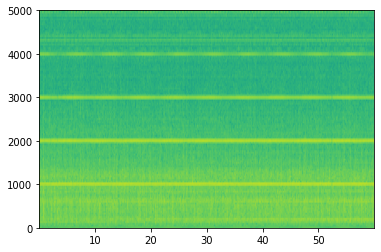

In [ ]:
sw.plot_spectrogram(recording, channel = 0)

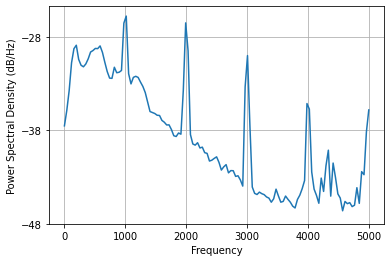

In [ ]:
sw.plot_spectrum(recording)

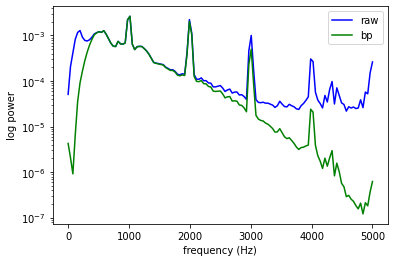

In [ ]:
bp_filtered = st.preprocessing.bandpass_filter(recording=recording, freq_min = 300, freq_max = 3000) #arbitrary
#notch_filtered = st.preprocessing.notch_filter(recording=recording, freq = 1000, q = 10)#arbitrary again

#plotting the power spectra of non-filtered vs bp-filtered vs notch filtered recs
#need explanation
#also, why are the plots showing variation when only only bp or notch ot raw is plotted?

f_raw, p_raw = scipy.signal.welch(recording.get_traces(), fs = recording.get_sampling_frequency())
f_bp, p_bp = scipy.signal.welch(bp_filtered.get_traces(), fs = bp_filtered.get_sampling_frequency())
#f_notch, p_notch = scipy.signal.welch(notch_filtered.get_traces(), fs = notch_filtered.get_sampling_frequency())

fig, ax = plt.subplots()
ax.semilogy(f_raw, p_raw[0], c = 'blue', label = 'raw')
#ax.semilogy(f_notch, p_notch[0], c = 'red', label = 'notch')
ax.semilogy(f_bp, p_bp[0], c = 'green', label = 'bp')
ax.set_ylabel('log power')
ax.set_xlabel('frequency (Hz)')
plt.legend();




In [ ]:
print(ss.installed_sorter_list)
print(ss.Mountainsort4Sorter.default_params())

[<class 'spikesorters.mountainsort4.mountainsort4.Mountainsort4Sorter'>, <class 'spikesorters.herdingspikes.herdingspikes.HerdingspikesSorter'>]
{'detect_sign': -1, 'adjacency_radius': -1, 'freq_min': 300, 'freq_max': 6000, 'filter': True, 'whiten': True, 'curation': False, 'num_workers': None, 'clip_size': 50, 'detect_threshold': 3, 'detect_interval': 10, 'noise_overlap_threshold': 0.15}


WARNING! No channel location given. Add dummy location.
Warning! The recording is already filtered, but Mountainsort4 filter is enabled. You can disable filters by setting 'filter' parameter to False
Warning! The recording is already filtered, but Mountainsort4 filter is enabled. You can disable filters by setting 'filter' parameter to False
Warning! The recording is already filtered, but Mountainsort4 filter is enabled. You can disable filters by setting 'filter' parameter to False
Warning! The recording is already filtered, but Mountainsort4 filter is enabled. You can disable filters by setting 'filter' parameter to False


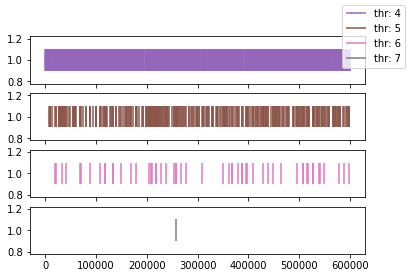

In [ ]:
default_ms4_params = ss.Mountainsort4Sorter.default_params()
default_ms4_params['curation'] = False
f, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex = True)
listax = [ax1, ax2, ax3, ax4]
for i, item in enumerate(listax):

  default_ms4_params['detect_threshold'] = i+4
  sorted_ms4 = ss.run_mountainsort4(recording = bp_filtered, **default_ms4_params)
  item.eventplot(sorted_ms4.get_unit_spike_train(1), linelengths=0.2,colors = f'C{i+4}', label = f'thr: {i+4}' )

f.legend()


In [ ]:
default_ms4_params = ss.Mountainsort4Sorter.default_params()
default_ms4_params['detect_threshold'] = 5

sorted_ms4 = ss.run_mountainsort4(recording = bp_filtered, **default_ms4_params)
print(sorted_ms4)

Warning! The recording is already filtered, but Mountainsort4 filter is enabled. You can disable filters by setting 'filter' parameter to False


[1]
(300, 1, 60)


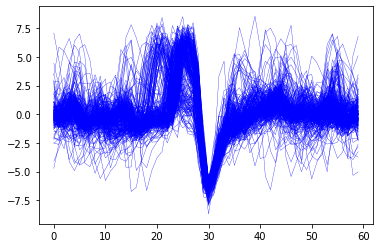

In [ ]:
print(sorted_ms4.get_unit_ids())
wf = st.postprocessing.get_unit_waveforms(bp_filtered, sorted_ms4, channel_ids=0,
                                          save_as_features=True, verbose=True)
print(wf[0].shape)
fig, ax = plt.subplots()
ax.plot(wf[0][:, 0, :].T, color='b', lw=0.3);





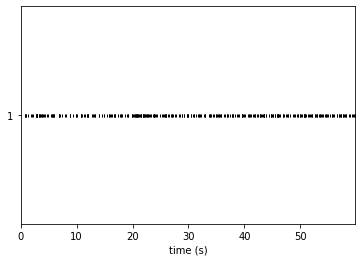

In [ ]:
sw.plot_rasters(sorted_ms4)


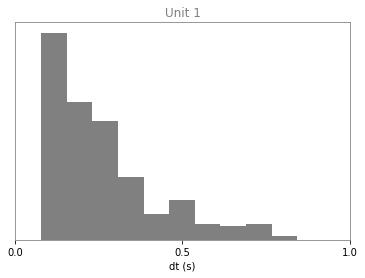

In [ ]:
sw.plot_isi_distribution(sorted_ms4, bins=10, window=1)

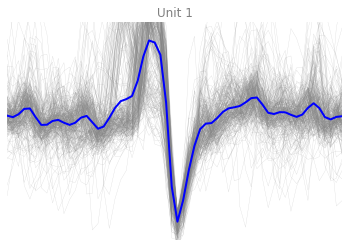

In [ ]:
sw.plot_unit_waveforms(bp_filtered, sorted_ms4, max_spikes_per_unit=100)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


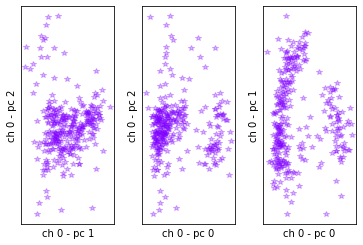

In [ ]:
sw.plot_pca_features(bp_filtered, sorted_ms4, colormap='rainbow', nproj=3, max_spikes_per_unit=100)

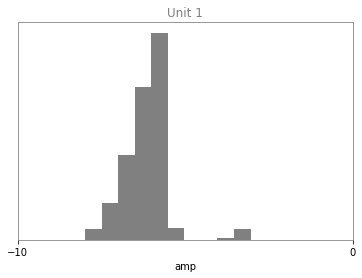

In [ ]:
sw.plot_amplitudes_distribution(bp_filtered, sorted_ms4, max_spikes_per_unit=300)

In [ ]:
metrics = st.validation.compute_quality_metrics(sorting=sorted_ms4, recording=bp_filtered,
                                                metric_names=['firing_rate', 'isi_violation', 'snr', 'nn_hit_rate', 'nn_miss_rate'],
                                                as_dataframe=True)
print(metrics)

   firing_rate  isi_violation       snr  nn_hit_rate  nn_miss_rate
1     5.433333       0.194679  7.542524          1.0           NaN


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
